## Main

In [4]:
# Load Model

from pycocotools.coco import COCO
import layoutparser as lp
import random
import cv2

model = lp.models.Detectron2LayoutModel(
    config_path = "config.yaml",
    model_path = "model_final.pth",
    label_map = {0 : "topic",
1 : "title",
2 : "contents",
3 : "figure",
4 : "graph",
5: "table",
6 : "table_caption",
7 : "comment"},
    extra_config = ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8] # <-- Only output high accuracy preds
)

In [5]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Inference example
import numpy as np
image = Image.open(f'example{11}.jpg')
image_array = np.array(image)

layout = model.detect(image_array)

# post process
topic_blocks = lp.Layout([b for b in layout if b.type == "topic"])
title_blocks = lp.Layout([b for b in layout if b.type == "title"])
text_blocks = lp.Layout([b for b in layout if b.type == "contents"])

figure_blocks = lp.Layout([b for b in layout if b.type == "figure"])
graph_blocks =  lp.Layout([b for b in layout if b.type == "graph"])
table_blocks =  lp.Layout([b for b in layout if b.type == "table"])
table_caption_blocks =  lp.Layout([b for b in layout if b.type == "table_caption"])
comment_blocks =  lp.Layout([b for b in layout if b.type == "comment"])
# 중복 제외
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [6]:
def match_comments(figure_blocks,graph_blocks,table_blocks,table_caption_blocks,comment_blocks):    
    '''
    outpout type : list of dictionary
    type : String => table, graph, figure
    main_bbox : Rectangle => 각 type의 메인 bbox (comments나 caption이 아님, 즉 표나 그래프나 사진의 bbox)
    comments : list of Rectangle  => 한 figure안에 여러 comments가 있을 수도 있음
    caption : Rectangle => type이 table인 경우만 있음
    '''
    output =[]
    # match talbe - comments - caption
    for table_block in table_blocks:
        comments_near_table = []
        for comment_block in comment_blocks:
            comment_y_center = (comment_block.block.y_1 + comment_block.block.y_2) / 2
            comment_x_center = (comment_block.block.x_1 + comment_block.block.x_2) / 2
            if (abs(comment_y_center - table_block.block.y_1 ) <= 80  or abs(comment_y_center - table_block.block.y_2) <= 80) and (comment_x_center < table_block.block.x_2  and comment_x_center > table_block.block.x_1):
                comments_near_table.append(comment_block.block)
        table_caption = []
        y_value_constraints = 150
        for table_caption_block in table_caption_blocks:
            table_caption_x_center = (table_caption_block.block.x_1 + table_caption_block.block.x_2) /2
            table_caption_y_center = (table_caption_block.block.y_1 + table_caption_block.block.y_2) /2
            y1_near = abs(table_caption_y_center - table_block.block.y_1 )
            y2_near = abs(table_caption_y_center - table_block.block.y_2)
            if ( y1_near <= y_value_constraints  or y2_near <= y_value_constraints) and ( table_caption_x_center < table_block.block.x_2  and table_caption_x_center > table_block.block.x_1):
                y_value_constraints = min(y1_near,y2_near)
                table_caption = table_caption_block.block
        output.append({"main_bbox" : table_block.block, "comments" : comments_near_table, "caption" : table_caption, "type" : "table" })
    # match graph - comments
    for  graph_block in graph_blocks:
        comments_near_table = []
        for comment_block in comment_blocks:
            comment_y_center = (comment_block.block.y_1 + comment_block.block.y_2) / 2
            comment_x_center = (comment_block.block.x_1 + comment_block.block.x_2) / 2
            if (abs(comment_y_center - graph_block.block.y_1 ) <= 80  or abs(comment_y_center - graph_block.block.y_2) <= 80) and (comment_x_center > graph_block.block.x_1 and comment_x_center < graph_block.block.x_2 ) : 
                comments_near_table.append(comment_block.block)
        
        output.append({"main_bbox" : graph_block.block, "comments" : comments_near_table, "type" : "graph"})

    # match graph - comments
    for figure_block in figure_blocks:
        comments_near_figure = []
        for comment_block in comment_blocks:
            comment_y_center = (comment_block.block.y_1 + comment_block.block.y_2) / 2
            comment_x_center = (comment_block.block.x_1 + comment_block.block.x_2) / 2
            if (abs(comment_y_center - figure_block.block.y_1 ) <= 80  or abs(comment_y_center - graph_block.block.y_2) <= 80) and (comment_x_center > graph_block.block.x_1 and comment_x_center < graph_block.block.x_2 ) : 
                comments_near_figure.append(comment_block.block)
        
        output.append({"main_bbox" : graph_block.block, "comments" : comments_near_table, "type" : "figure"})

    return output


results = match_comments(figure_blocks,graph_blocks,table_blocks,table_caption_blocks,comment_blocks)

In [10]:
results

[{'main_bbox': Rectangle(x_1=108.54010772705078, y_1=1186.937255859375, x_2=1048.1182861328125, y_2=1472.5047607421875),
  'comments': [Rectangle(x_1=734.38330078125, y_1=1155.5621337890625, x_2=1066.551025390625, y_2=1188.3935546875)],
  'caption': Rectangle(x_1=116.8840560913086, y_1=1105.9173583984375, x_2=1030.4866943359375, y_2=1151.6326904296875),
  'type': 'table'},
 {'main_bbox': Rectangle(x_1=1285.0582275390625, y_1=906.0853271484375, x_2=2226.625, y_2=1486.4339599609375),
  'comments': [Rectangle(x_1=1888.8333740234375, y_1=867.103515625, x_2=2226.18017578125, y_2=902.9047241210938)],
  'caption': Rectangle(x_1=1289.7884521484375, y_1=818.332275390625, x_2=2235.312744140625, y_2=866.4725952148438),
  'type': 'table'},
 {'main_bbox': Rectangle(x_1=107.5711441040039, y_1=586.6480102539062, x_2=1103.4681396484375, y_2=929.9920654296875),
  'comments': [Rectangle(x_1=112.61138153076172, y_1=924.4011840820312, x_2=282.3001708984375, y_2=950.9964599609375)],
  'type': 'graph'}]

In [9]:
results[0]['main_bbox'].coordinates

(108.54010772705078, 1186.937255859375, 1048.1182861328125, 1472.5047607421875)

### 아래는 내가 테스트한거

In [4]:
# Load Model

from pycocotools.coco import COCO
import layoutparser as lp
import random
import cv2

model = lp.models.Detectron2LayoutModel(
    config_path = "config.yaml",
    model_path = "model_final.pth",
    label_map = {0 : "topic",
1 : "title",
2 : "contents",
3 : "figure",
4 : "graph",
5: "table",
6 : "table_caption",
7 : "comment"},
    extra_config = ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8] # <-- Only output high accuracy preds
)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (9, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (9,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (32, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (32,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weig

In [5]:
from PIL import Image
import torchvision.transforms as transforms
import torch

TypeError: 'ImagingCore' object is not callable

In [15]:
# Inference
import time
import numpy as np
# image = Image.open(f'example{11}.jpg')
image = Image.open(f'/root/OpenAI_SKT/openai_skt/tutorials/1695295887.2628477.png')
image_array = np.array(image)

layout = model.detect(image_array)
table =  lp.Layout([b for b in layout if b.type == "comment" or b.type == "table" or b.type == "graph"or b.type == "table_caption" or b.type == "figure" or b.type=="contents"])

lp.draw_box(image,table, color_map={"contents":"grey", "table_caption" : "pink","comment" : "red", "table" : "blue", "graph" : "green", "figure" : "black" })


RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

In [14]:
topic_blocks = lp.Layout([b for b in layout if b.type == "topic"])
title_blocks = lp.Layout([b for b in layout if b.type == "title"])
text_blocks = lp.Layout([b for b in layout if b.type == "contents"])

figure_blocks = lp.Layout([b for b in layout if b.type == "figure"])
graph_blocks =  lp.Layout([b for b in layout if b.type == "graph"])
table_blocks =  lp.Layout([b for b in layout if b.type == "table"])
table_caption_blocks =  lp.Layout([b for b in layout if b.type == "table_caption"])
comment_blocks =  lp.Layout([b for b in layout if b.type == "comment"])
# 중복 제외
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [15]:
def match_comments(figure_blocks,graph_blocks,table_blocks,table_caption_blocks,comment_blocks):    
    '''
    outpout type : list of dictionary
    type : String => table, graph, figure
    main_bbox : Rectangle => 각 type의 메인 bbox (comments나 caption이 아님, 즉 표나 그래프나 사진의 bbox)
    comments : list of Rectangle  => 한 figure안에 여러 comments가 있을 수도 있음
    caption : Rectangle => type이 table인 경우만 있음
    '''
    output =[]
    # match talbe - comments - caption
    for table_block in table_blocks:
        comments_near_table = []
        for comment_block in comment_blocks:
            comment_y_center = (comment_block.block.y_1 + comment_block.block.y_2) / 2
            comment_x_center = (comment_block.block.x_1 + comment_block.block.x_2) / 2
            if (abs(comment_y_center - table_block.block.y_1 ) <= 80  or abs(comment_y_center - table_block.block.y_2) <= 80) and (comment_x_center < table_block.block.x_2  and comment_x_center > table_block.block.x_1):
                comments_near_table.append(comment_block.block)
        table_caption = []
        y_value_constraints = 150
        for table_caption_block in table_caption_blocks:
            table_caption_x_center = (table_caption_block.block.x_1 + table_caption_block.block.x_2) /2
            table_caption_y_center = (table_caption_block.block.y_1 + table_caption_block.block.y_2) /2
            y1_near = abs(table_caption_y_center - table_block.block.y_1 )
            y2_near = abs(table_caption_y_center - table_block.block.y_2)
            if ( y1_near <= y_value_constraints  or y2_near <= y_value_constraints) and ( table_caption_x_center < table_block.block.x_2  and table_caption_x_center > table_block.block.x_1):
                y_value_constraints = min(y1_near,y2_near)
                table_caption = table_caption_block.block
        output.append({"main_bbox" : table_block.block, "comments" : comments_near_table, "caption" : table_caption, "type" : "table" })
    # match graph - comments
    for  graph_block in graph_blocks:
        comments_near_table = []
        for comment_block in comment_blocks:
            comment_y_center = (comment_block.block.y_1 + comment_block.block.y_2) / 2
            comment_x_center = (comment_block.block.x_1 + comment_block.block.x_2) / 2
            if (abs(comment_y_center - graph_block.block.y_1 ) <= 80  or abs(comment_y_center - graph_block.block.y_2) <= 80) and (comment_x_center > graph_block.block.x_1 and comment_x_center < graph_block.block.x_2 ) : 
                comments_near_table.append(comment_block.block)
        
        output.append({"main_bbox" : graph_block.block, "comments" : comments_near_table, "type" : "graph"})

    # match graph - comments
    
    for figure_block in figure_blocks:
        comments_near_figure = []
        for comment_block in comment_blocks:
            comment_y_center = (comment_block.block.y_1 + comment_block.block.y_2) / 2
            comment_x_center = (comment_block.block.x_1 + comment_block.block.x_2) / 2
            if (abs(comment_y_center - figure_block.block.y_1 ) <= 80  or abs(comment_y_center - graph_block.block.y_2) <= 80) and (comment_x_center > graph_block.block.x_1 and comment_x_center < graph_block.block.x_2 ) : 
                comments_near_figure.append(comment_block.block)
        
        output.append({"main_bbox" : graph_block.block, "comments" : comments_near_table, "type" : "figure"})

    return output


In [16]:
result = match_comments(figure_blocks,graph_blocks,table_blocks,table_caption_blocks,comment_blocks)

In [17]:
result

[]

In [32]:
import matplotlib.pyplot as plt
segment_image = (table_blocks[0]
                    .pad(left=5, right=5, top=5, bottom=5)
                     .crop_image(image_array))


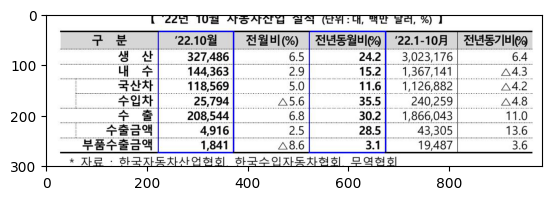

In [33]:


plt.imshow(segment_image)